## Outline
This notebook was run after retrieving cell type annotations. Here we investigate that the Scapula samples have 
systematically lower counts compared to other bones. Since this might be due to sample quality differences Scapula
was excluded in some analyses.

In [1]:
DATA_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_VERSION = 'oct22'#'april21'
RESULTS_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
SHAM = True

########################################################################################
sham_str = '_wSham' if SHAM else ''

In [2]:
import os 
import numpy as np
import itertools
import scipy as sci
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import scanpy as sc
import anndata as ann

from scipy.sparse import csr_matrix, issparse
import matplotlib
from matplotlib import rcParams
from matplotlib import colors


sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              1.0.9
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
cloudpickle         1.6.0
constants           NA
cycler              0.10.0
cython_runtime      NA
dask                2020.12.0
dateutil            2.8.1
decorator           4.4.2
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.2
joblib              1.0.0
json5               NA
jsonschema          3.2.0
jupyter_server      1.2.1
jupyterlab_server   2.1.2
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg

# Investigate the counts in each cell type per bone
We find that Scapula consistently shows lower counts than the other bones.

In [3]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')

In [7]:
# Rename Skull to Calvaria
adata.obs["region"].cat.rename_categories({'Skull': 'Calvaria'}, inplace=True)

In [4]:
plt.rcParams['figure.dpi'] = 150
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

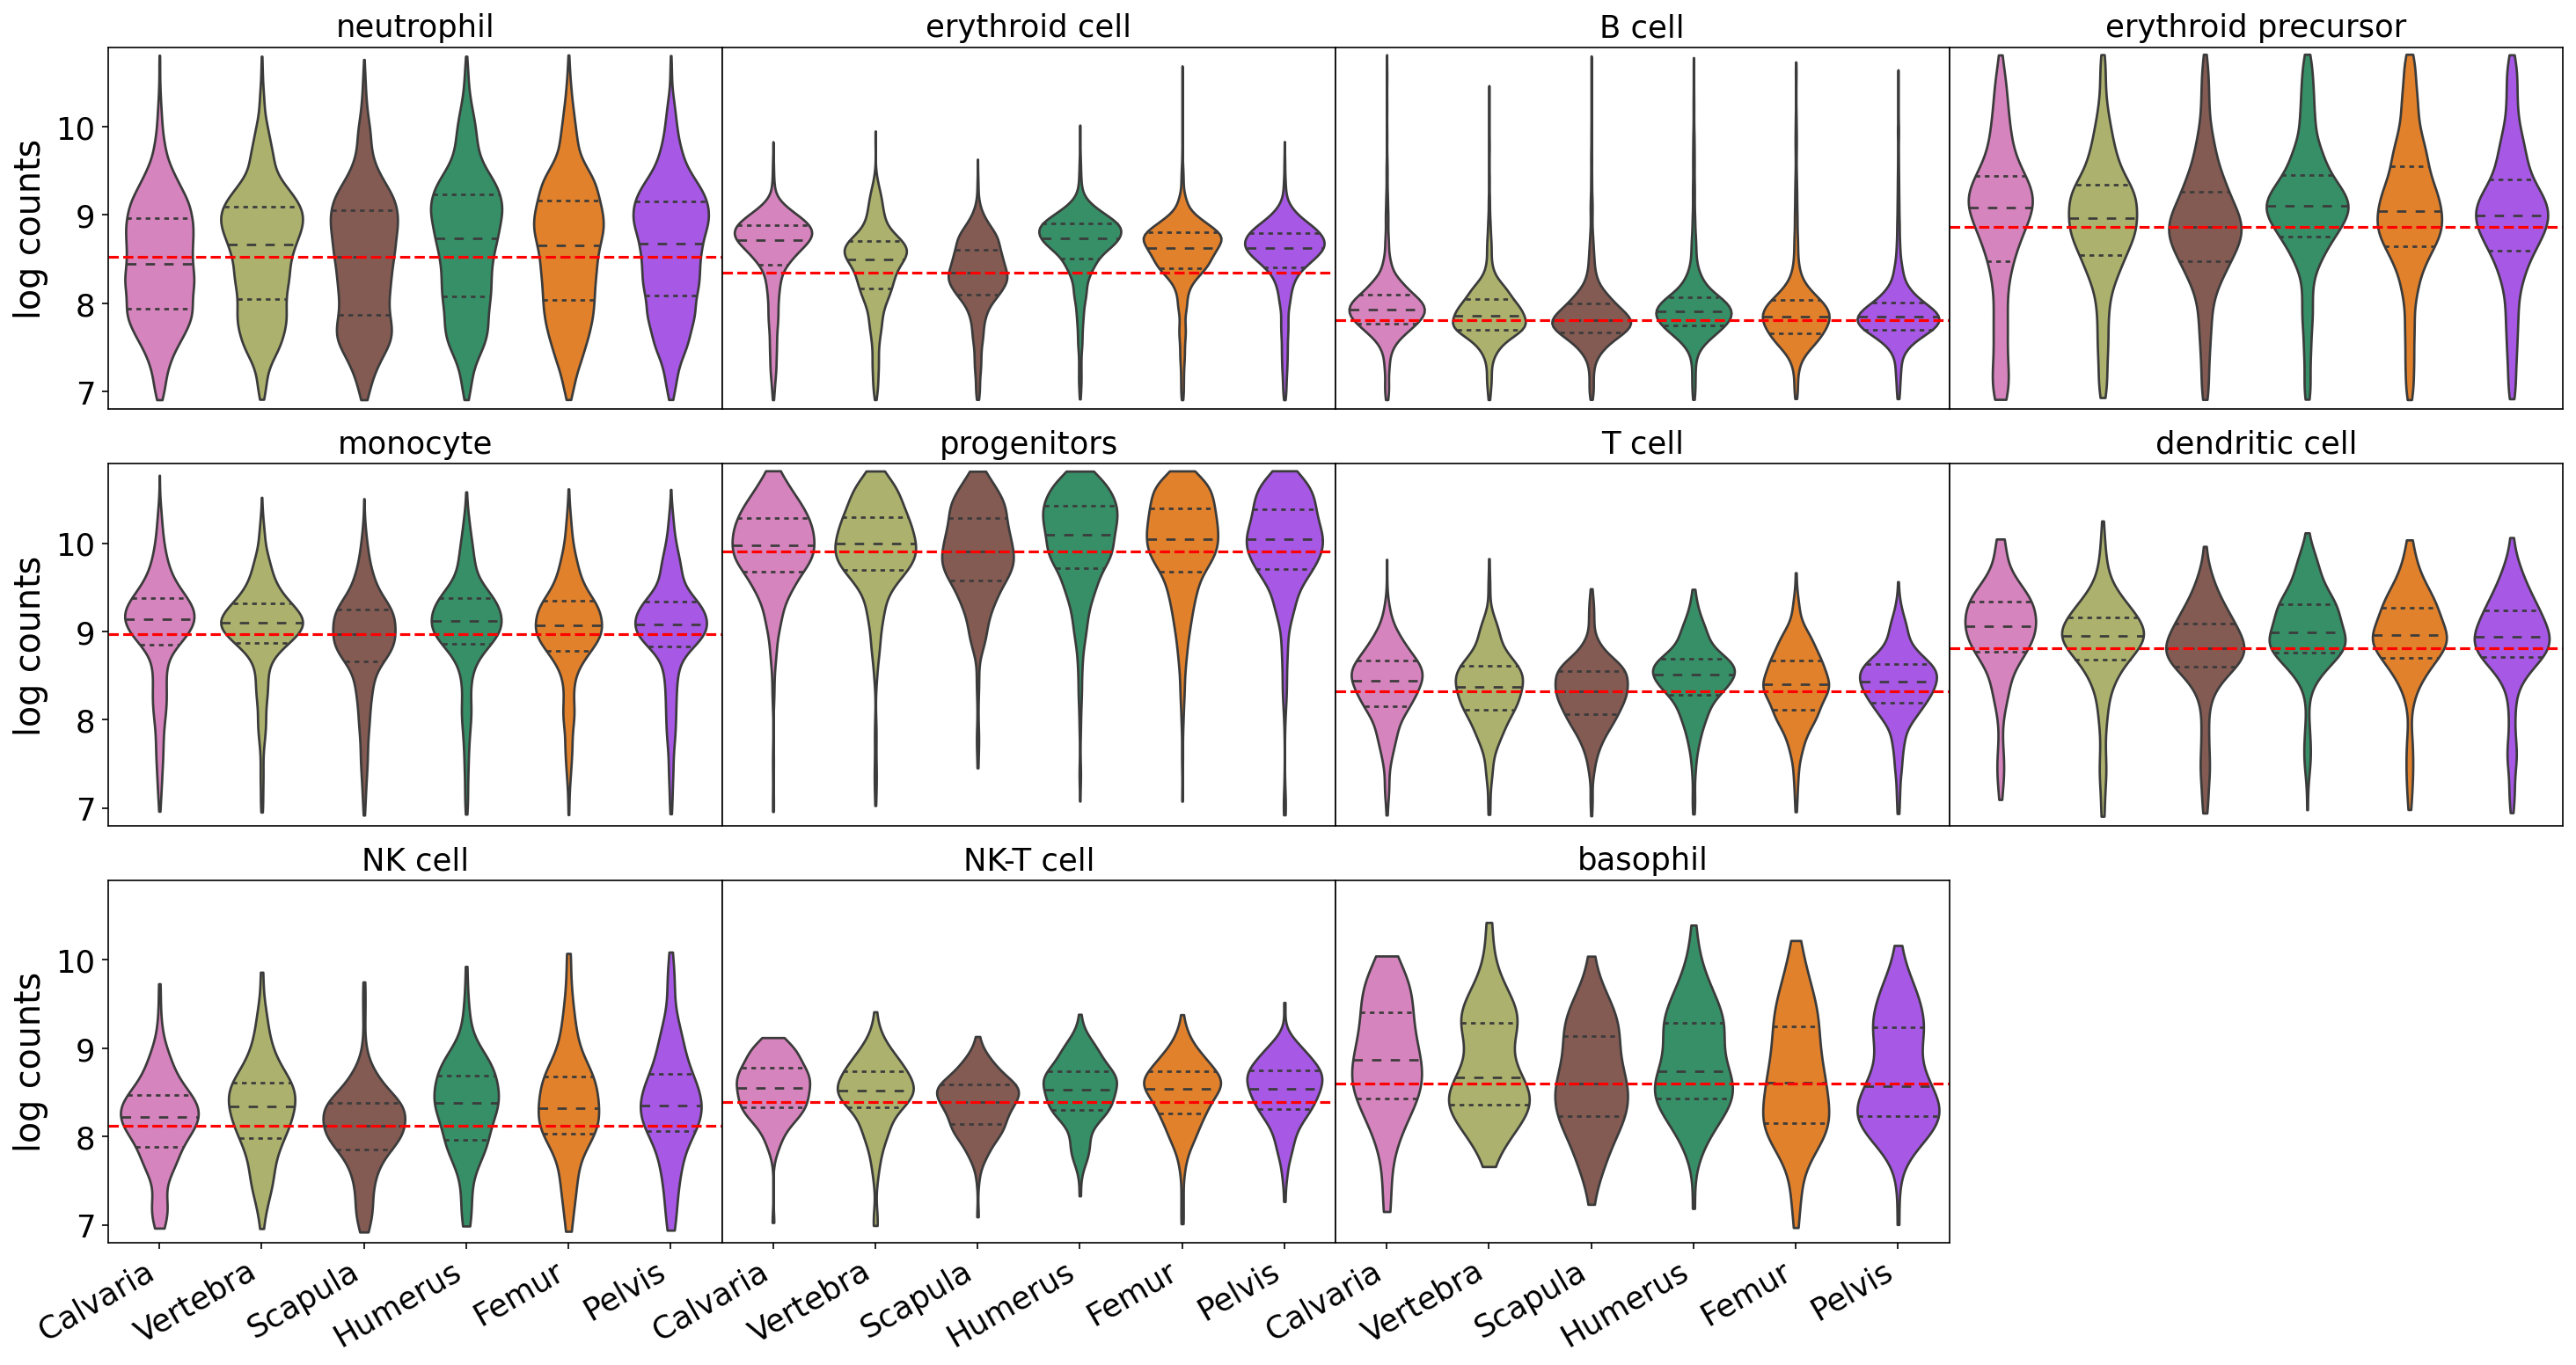

In [9]:
from matplotlib import gridspec

ct_key = "level1"

bones = ["Calvaria","Vertebra","Scapula","Humerus","Femur","Pelvis"]
#bones = ["Skull","Vertebra","Scapula","Humerus","Femur","Pelvis"]

colors = [adata.uns["region_colors"][adata.obs["region"].cat.categories.tolist().index(bone)] for bone in bones]

df = sc.get.obs_df(adata[adata.obs["region"].isin(bones)], ['n_genes', 'n_counts', 'region', 'condition', ct_key])
df['log_counts'] = np.log(df['n_counts'])

val_counts = df[ct_key].value_counts()
ct_filter_and_order = val_counts.loc[val_counts > 400].index.tolist()

df = df.loc[df[ct_key].isin(ct_filter_and_order)]
df = df.sort_values(ct_key,ascending=False)

ncols=4
nrows=len(ct_filter_and_order)//ncols + int((len(ct_filter_and_order)%ncols) > 0)


fig = plt.figure(figsize=(6*ncols, 4*nrows))

gs = gridspec.GridSpec(nrows, ncols,wspace=0.0, hspace=0.15)
for i,ct in enumerate(ct_filter_and_order):
    row = i//ncols
    col = i%ncols
    ax=plt.subplot(gs[row,col])
    sns.violinplot(data=df.loc[df[ct_key] == ct], x='region', y="log_counts", inner="quart",
                   linewidth=1.3,cut=0,ax=ax,order=bones, palette=colors)
    scapula_med = df.loc[(df[ct_key] == ct) & (df["region"] == "Scapula"),"log_counts"].median()
    ax.axhline(y=scapula_med, color='red', linestyle='--')
    plt.ylim([6.8,10.9]) 
    plt.xlabel("")    
    if col == 0:
        plt.ylabel("log counts")
    else:
        ax.set(yticks=[])
        plt.ylabel("")
    if row != (nrows-1):
        ax.set(xticks=[])
    else:      
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha="right")
    plt.title(ct)
        
plt.show()
fig.savefig("./figures/scapula_systematic_low_counts.pdf", bbox_inches = "tight")